In [1]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from catboost import CatBoostRegressor
warnings.filterwarnings("ignore")
from typing import TypeVar, List, Dict, Tuple
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')

# Refs: https://www.kaggle.com/byfone/basic-feature-feat-catboost
# Refs: https://www.kaggle.com/kernels/scriptcontent/13873316/download

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/LANL/"
else:
    PATH="../input/"
os.listdir(PATH)

train_X = pd.read_csv(os.path.join(PATH,'../input/all-features/train_X.csv'))
train_y = pd.read_csv(os.path.join(PATH,'../input/all-features/train_y.csv'))
train_X.shape, train_y.shape

((4194, 1620), (4194, 1))

In [3]:
submission = pd.read_csv(os.path.join(PATH,'LANL-Earthquake-Prediction/sample_submission.csv'), index_col='seg_id')
test_X = pd.read_csv(os.path.join(PATH,'../input/all-features/test_X.csv'))
submission.shape, test_X.shape

((2624, 1), (2624, 1620))

In [4]:
"""Use cross-validation (e.g., KFold)"""
def fold_generator(x, y, groups=None, num_folds=10, shuffle=True, seed=2019):
    folds = KFold(num_folds, shuffle=shuffle, random_state=seed)
    for train_index, test_index in folds.split(x, y, groups):
        yield train_index, test_index

In [5]:
"""Search the hyperparameters and return the estimator with the best parameters"""
def search_cv(x, y, model, grid, max_iter=None, num_folds=10, shuffle=True):
    t0 = time.time()
    
    cv = fold_generator(x, y, num_folds=num_folds)
    if max_iter is None:
        # Exhaustive search over specified parameter values for an estimator (model)
        search = GridSearchCV(model, grid, cv=cv,
                              scoring='neg_mean_absolute_error')
    else:
        # Randomized search on hyper parameters with 
        # The number of parameter settings that are tried is given by n_iter (not all parameter values are tried out)
        search = RandomizedSearchCV(model, grid, n_iter=max_iter, cv=cv,
                                    scoring='neg_mean_absolute_error')
    search.fit(x, y, silent=True)
    
    t0 = time.time() - t0
    print("Best CV score: {:.4f}, time: {:.1f}s".format(-search.best_score_, t0))
    print(search.best_params_)
    return search.best_estimator_

In [6]:
"""Train, make predictions & plot results"""
def make_predictions(x, y, model, num_folds=10, shuffle=True, test=None, plot=True):
    if test is not None:
        sub_prediction = np.zeros(test.shape[0])
        
    oof_prediction = np.zeros(x.shape[0])
    # use cross-validation (10-fold cross-validation)
    for tr_idx, val_idx in fold_generator(x, y, num_folds=num_folds):
        model.fit(x.iloc[tr_idx], y.iloc[tr_idx])
        oof_prediction[val_idx] = model.predict(x.iloc[val_idx])

        if test is not None:
            sub_prediction += model.predict(test) / num_folds
    
    if plot:
        plot_predictions(y, oof_prediction)
    if test is None:
        return oof_prediction
    else:
        return oof_prediction, sub_prediction

In [7]:
def plot_predictions(y, oof_predictions):
    """Plot out-of-fold predictions vs actual values."""
    fig, axis = plt.subplots(1, 2, figsize=(14, 6))
    ax1, ax2 = axis
    ax1.set_xlabel('actual')
    ax1.set_ylabel('predicted')
    ax1.set_ylim([-5, 20])
    ax2.set_xlabel('train index')
    ax2.set_ylabel('time to failure')
    ax2.set_ylim([-2, 18])
    ax1.scatter(y, oof_predictions, color='brown')
    ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
    ax2.plot(y, color='blue', label='y_train')
    ax2.plot(oof_predictions, color='orange')

In [8]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)
scaled_test_X.shape

(2624, 1620)

In [9]:
grid = {
    'depth': [4, 6, 8],
    'random_seed' : [400, 100, 200],
    'learning_rate' : [0.01, 0.03, 0.1]
}
cat_model = CatBoostRegressor(loss_function='MAE', task_type = "GPU")
cat_model = search_cv(scaled_train_X, train_y, cat_model, grid, max_iter=3)

Best CV score: 2.0174, time: 784.2s
{'random_seed': 200, 'learning_rate': 0.1, 'depth': 4}


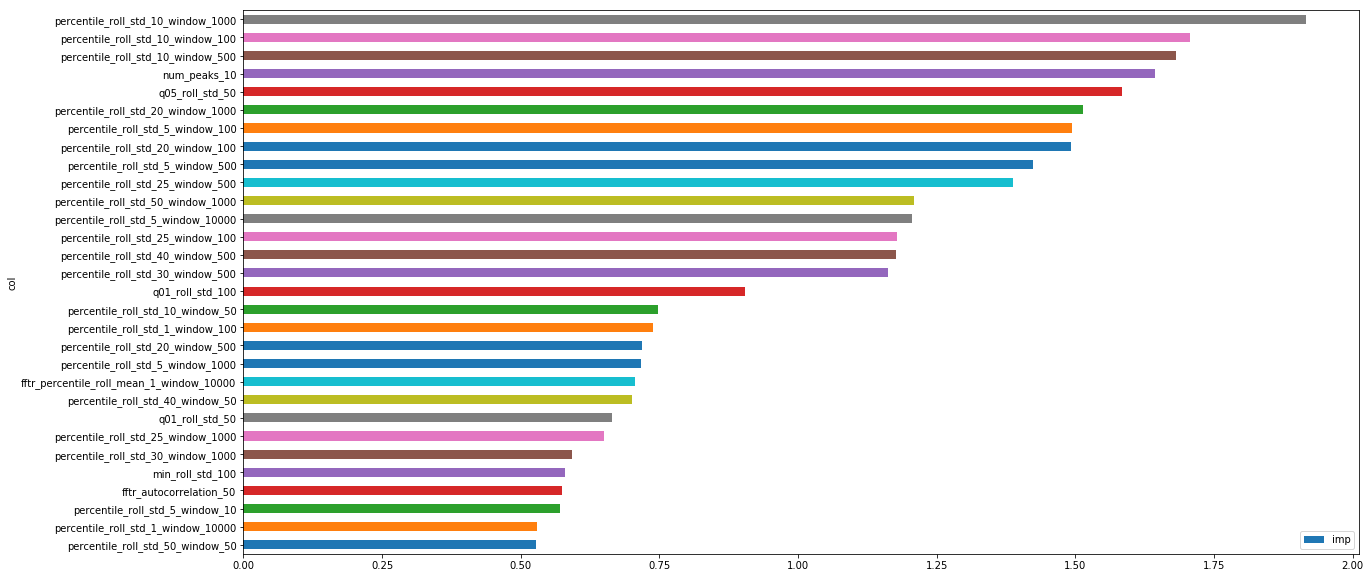

In [10]:
# Feature Importance
fea_imp = pd.DataFrame({'imp': cat_model.feature_importances_, 'col': scaled_train_X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')  

0:	learn: 5.6651721	total: 20.2ms	remaining: 20.1s
1:	learn: 5.6167756	total: 40.6ms	remaining: 20.3s
2:	learn: 5.5688562	total: 58ms	remaining: 19.3s
3:	learn: 5.5219382	total: 77.6ms	remaining: 19.3s
4:	learn: 5.4760393	total: 95.7ms	remaining: 19s
5:	learn: 5.4311122	total: 115ms	remaining: 19.1s
6:	learn: 5.3864626	total: 134ms	remaining: 19s
7:	learn: 5.3427005	total: 152ms	remaining: 18.9s
8:	learn: 5.2991966	total: 171ms	remaining: 18.8s
9:	learn: 5.2568313	total: 189ms	remaining: 18.7s
10:	learn: 5.2152448	total: 207ms	remaining: 18.6s
11:	learn: 5.1743312	total: 227ms	remaining: 18.7s
12:	learn: 5.1341508	total: 245ms	remaining: 18.6s
13:	learn: 5.0947571	total: 264ms	remaining: 18.6s
14:	learn: 5.0561686	total: 283ms	remaining: 18.6s
15:	learn: 5.0183197	total: 302ms	remaining: 18.6s
16:	learn: 4.9811798	total: 321ms	remaining: 18.6s
17:	learn: 4.9443773	total: 341ms	remaining: 18.6s
18:	learn: 4.9081157	total: 360ms	remaining: 18.6s
19:	learn: 4.8729775	total: 379ms	remainin

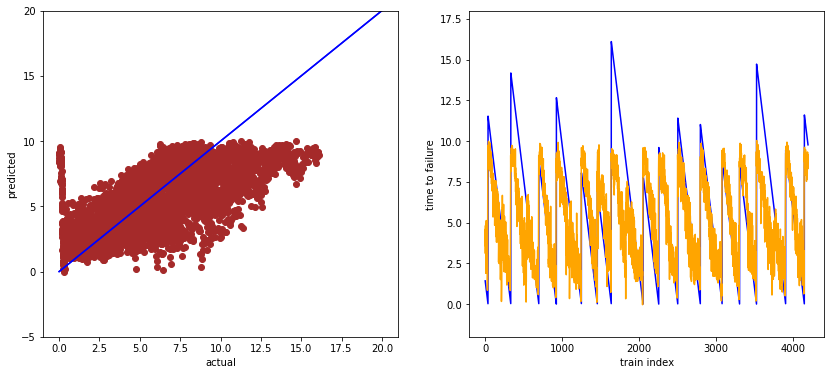

In [11]:
oof = make_predictions(scaled_train_X, train_y, cat_model)

In [12]:
oof, sub = make_predictions(scaled_train_X, train_y, cat_model,
                                  test=scaled_test_X, plot=False)

0:	learn: 5.6651721	total: 20.7ms	remaining: 20.7s
1:	learn: 5.6167756	total: 45.8ms	remaining: 22.9s
2:	learn: 5.5688562	total: 64.8ms	remaining: 21.6s
3:	learn: 5.5219382	total: 86.1ms	remaining: 21.4s
4:	learn: 5.4760393	total: 106ms	remaining: 21s
5:	learn: 5.4311122	total: 127ms	remaining: 21s
6:	learn: 5.3864626	total: 147ms	remaining: 20.8s
7:	learn: 5.3427005	total: 167ms	remaining: 20.7s
8:	learn: 5.2991966	total: 186ms	remaining: 20.5s
9:	learn: 5.2568313	total: 212ms	remaining: 21s
10:	learn: 5.2152448	total: 232ms	remaining: 20.8s
11:	learn: 5.1743312	total: 251ms	remaining: 20.7s
12:	learn: 5.1341508	total: 270ms	remaining: 20.5s
13:	learn: 5.0947571	total: 289ms	remaining: 20.3s
14:	learn: 5.0561686	total: 308ms	remaining: 20.2s
15:	learn: 5.0183197	total: 328ms	remaining: 20.2s
16:	learn: 4.9811798	total: 348ms	remaining: 20.1s
17:	learn: 4.9443773	total: 370ms	remaining: 20.2s
18:	learn: 4.9081157	total: 389ms	remaining: 20.1s
19:	learn: 4.8729775	total: 410ms	remaining

In [13]:
submission.time_to_failure = sub
submission.to_csv('submission.csv',index=True)